In [146]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges
            
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right 
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=str(id(n)), label = "{data %.4f | grad %.4f }" % (           n.data, n.grad), shape='record')

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)))

    return dot

In [ ]:
import math

class Scalar:

    def __init__(self, data, children=()):
        self.data = data
        self.grad = 0.0
        self._backward = None
        self.prev = children

    def __repr__(self):
        return f"Scalar={self.data}"

    #operations    
    def __mul__(self, other):
        output = Scalar(self.data * other.data, (self,other))
        def _backward():
            self.grad += output.grad * other.data
            other.grad += output.grad * self.data
        output._backward = _backward
        return output
    
    def __add__(self, other):            
        output = Scalar(self.data + other.data, (self,other))
        def _backward():
            self.grad += output.grad
            other.grad += output.grad
        output._backward = _backward
        return output
    
    def __sub__(self,other):
        output = Scalar(self.data + (-other.data), (self,other))
        def _backward():
            self.grad += output.grad
            other.grad += output.grad
        output._backward = _backward
        return output

    def __neg__(self):
        output = Scalar(-self.data, (self,))
        def _backward():
            self.grad += -output.grad
        output._backward = _backward
        return output
    
    def __div__(self, other):
        output = Scalar(self.data * other.data**-1, (self,other))
        def _backward():
            self.grad += output.grad / other.data
            other.grad += -output.grad * self.data / (other.data * other.data)
        output._backward = _backward
        return output

    #non linearities
    def exp(self):
        output = Scalar(math.exp(self.data), (self,))
        def _backward():
            self.grad += output.grad * output.data
        output._backward = _backward
        return output

    def __pow__(self, exponent):
        output = Scalar(self.data ** exponent, (self,))
        def _backward():
            self.grad += output.grad * (exponent * (self.data ** (exponent - 1)))
        output._backward = _backward
        return output
    
    #activation
    def relu(self):
        output = Scalar(max(0,self.data), (self,))
        def _backward():
            self.grad += output.grad * (1.0 if max(0,self.data) != 0 else 0.0)
        output._backward = _backward
        return output

    def sigmoid(self):
        output = Scalar( (1 + math.exp(self.data))**-1)
        def _backward():
            self.grad += output.grad * (output.data * (1.0 - output.data))
        output._backward = _backward
        return output
    
    def backward(self):
        self.grad = 1.0

        topo = []
        visited = set()
        stack = [(self, False)]  # (node, expanded?)

        while len(stack) > 0:
            node, expanded = stack.pop()

            if expanded:
                topo.append(node)
                continue

            if node in visited:
                continue

            visited.add(node)

            # postorder
            stack.append((node, True))
            for child in reversed(node.prev):
                if child not in visited:
                    stack.append((child, False))

        # run backprop
        for node in reversed(topo):
            if node._backward is not None:
                node._backward()

In [161]:
#forward
g = Scalar(1)
h = Scalar(2)
j = Scalar(3)
m = Scalar(4)

c = g * h
i = c + j
L = i * m

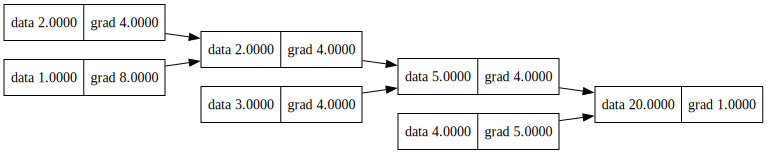

In [158]:
draw_dot(L)

In [163]:
L.backward()

stack: [(Scalar=20, False)]
visited:  set()
topo:  []
stack: [(Scalar=20, True), (Scalar=4, False), (Scalar=5, False)]
visited:  {Scalar=20}
topo:  []
stack: [(Scalar=20, True), (Scalar=4, False), (Scalar=5, True), (Scalar=3, False), (Scalar=2, False)]
visited:  {Scalar=20, Scalar=5}
topo:  []
stack: [(Scalar=20, True), (Scalar=4, False), (Scalar=5, True), (Scalar=3, False), (Scalar=2, True), (Scalar=2, False), (Scalar=1, False)]
visited:  {Scalar=20, Scalar=5, Scalar=2}
topo:  []
stack: [(Scalar=20, True), (Scalar=4, False), (Scalar=5, True), (Scalar=3, False), (Scalar=2, True), (Scalar=2, False), (Scalar=1, True)]
visited:  {Scalar=20, Scalar=1, Scalar=5, Scalar=2}
topo:  []
stack: [(Scalar=20, True), (Scalar=4, False), (Scalar=5, True), (Scalar=3, False), (Scalar=2, True), (Scalar=2, False)]
visited:  {Scalar=20, Scalar=1, Scalar=5, Scalar=2}
topo:  [Scalar=1]
stack: [(Scalar=20, True), (Scalar=4, False), (Scalar=5, True), (Scalar=3, False), (Scalar=2, True), (Scalar=2, True)]
visit